In [1]:
#Python Basics
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import pickle
import requests
from bs4 import BeautifulSoup
import lyricsgenius

#NLP & ML
import editdistance as ed
from sklearn.pipeline import Pipeline
import gensim
import nltk
from nltk import pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import HdpModel, LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import tomotopy

import pyLDAvis.gensim as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
pd.set_option('display.max_rows', None)
clear_output(wait=True)

In [2]:
kanye = pd.read_pickle('kanye_modeling.pkl')
#Removing skit songs as they don't carry the same weight as regular songs
kanye = kanye.loc[~kanye.track.str.contains('Skit')].reset_index()
kanye.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,albums,track_number,track,writers,track_length,Year,old_kanye,clean_track,features,...,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_stopwords,mean_word_len,word_unique_percent,punct_percent,processed_lyrics
0,1,The College Dropout,2,We Don't Care,West Miri Ben-Ari Ross Vannelli,3:59,2004,1,We Don't Care,None,...,648,305,3329,171,7,259,4.120370,47.067901,26.388889,oh yeah get perfect song kid sing people drug ...
1,2,The College Dropout,3,Graduation Day,West John Stephens Ben-Ari,1:22,2004,1,Graduation Day,None,...,207,133,1113,53,5,98,4.376812,64.251208,25.603865,fuck kanye tell shit kid give muthafuckin grad...
2,3,The College Dropout,4,All Falls Down (featuring Syleena Johnson),West Lauryn Hill,3:43,2004,1,All Falls Down,Syleena_Johnson,...,766,315,3907,212,16,341,4.092689,41.122715,27.676240,oh fall yeah real one baby tellin fall uh chi ...
3,4,The College Dropout,5,I'll Fly Away,Albert E. Brumley,1:09,2004,1,I'll Fly Away,None,...,41,27,196,5,1,10,3.682927,65.853659,12.195122,one glad morning life fly away land joy shall ...
4,5,The College Dropout,6,Spaceship (featuring GLC and Consequence),West Leonard Harris Dexter Mills Marvin Gaye G...,5:24,2004,1,Spaceship,"GLC, Consequence",...,794,361,3945,153,53,350,3.959698,45.465995,19.269521,workin graveshift make shit wish could buy spa...


In [3]:
#returns the probabilities of each of the topics based on top word proababilities
def topic_prob_extractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# How many topics should we have for Kanye?

 - Check HDP and coherence score suggestions for optimal # of topics
     - We learn that HDP doesn't do a good job recommending a number of topics for Kanye. The topic importance probabilty extractor shows an even spread across all topics, but 4-5 are above a certain threshold (what and how is topic importance calculated?)
     - Coherence score is a good way to understand how well the tokens used to describe a topic make sense together (explain how that's calculated). Coherence measures how well each of the words within a topic get along with each other and make sense.
     
    
 - Check for topic word coverage overlap - find the optimal # of topics quantitatively
 - What are the topics and how would you classify the old albums with topics?
 

### HDP

In [4]:
kanye_dict = corpora.Dictionary(a.split() for a in kanye.processed_lyrics)
kanye_corpus = [kanye_dict.doc2bow(i.split()) for i in kanye.processed_lyrics]
kanye_words =[word_tokenize(kanye.processed_lyrics[i]) for i in range(len(kanye.processed_lyrics))]

kanye_hdp = HdpModel(
   corpus=kanye_corpus, id2word=kanye_dict, K=20, T=30
)

kanye_hdp.print_topics(num_topics=5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.003*know + 0.003*get + 0.003*thing + 0.002*nigga + 0.002*night + 0.002*na + 0.002*instrumental + 0.002*nick + 0.002*like + 0.002*see'),
 (1,
  '0.004*la + 0.002*bitch + 0.002*forever + 0.002*stroll + 0.002*tek + 0.002*get + 0.002*blame + 0.002*important + 0.002*incidental + 0.002*fuck'),
 (2,
  '0.002*like + 0.002*go + 0.002*round + 0.002*get + 0.002*ups + 0.002*know + 0.002*brother + 0.001*issue + 0.001*limbo + 0.001*girl'),
 (3,
  '0.002*woo + 0.002*swerve + 0.002*get + 0.002*know + 0.001*okay + 0.001*scrrr + 0.001*detonation + 0.001*calm + 0.001*leeway + 0.001*sped'),
 (4,
  '0.004*get + 0.002*gon + 0.002*well + 0.002*know + 0.002*rubber + 0.002*like + 0.001*meet + 0.001*blow + 0.001*na + 0.001*motherfuckers')]

In [5]:
weighted_topics = topic_prob_extractor(kanye_hdp)
weighted_topics['percentile_rank'] = weighted_topics.weight.rank(pct = True)
weighted_topics.sort_values('weight', ascending = False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_id,weight,percentile_rank
0,0,0.034640,1.00
1,1,0.033561,0.95
4,4,0.030649,0.90
2,2,0.029692,0.85
6,6,0.029572,0.80
18,18,0.028921,0.75
11,11,0.028877,0.70
9,9,0.028718,0.65
14,14,0.028660,0.60
5,5,0.028626,0.55


### LDA

Justify which coherence metric

In [6]:
#kanye_dict = corpora.Dictionary(a.split() for a in kanye.processed_lyrics)
#kanye_corpus = [kanye_dict.doc2bow(i.split()) for i in kanye.processed_lyrics]
#kanye_words =[tokenizer.tokenize(kanye.processed_lyrics[i]) for i in range(0, len(kanye.processed_lyrics))]

def kanyify(n):
    """
    n represents the number of topics to include in an LDA model
    coherence is either {'u_mass', 'c_v', 'c_uci', 'c_npmi'}
    Fastest method - ‘u_mass’, ‘c_uci’ also known as c_pmi. 
    For ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary.
    For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
    """
    model = gensim.models.LdaMulticore(corpus=kanye_corpus,
                                       id2word=kanye_dict,
                                       num_topics=n, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    
    coherence_c_v = CoherenceModel(model=model, texts=kanye_words,  coherence='c_v')
    coherence_c_uci = CoherenceModel(model=model, texts=kanye_words,  coherence='c_uci')    
    coherence_c_npmi = CoherenceModel(model=model, texts=kanye_words,  coherence='c_npmi')
    coherence_u_mass = CoherenceModel(model=model, corpus=kanye_corpus, coherence='u_mass')  
    
    coherence_list = [coherence_c_v.get_coherence(), coherence_c_uci.get_coherence(), 
                      coherence_c_npmi.get_coherence(), coherence_u_mass.get_coherence()]
    log_perplexity = model.log_perplexity(kanye_corpus)
    return model, coherence_list, log_perplexity


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:

#for i in [5, 6, 7, 8, 9, 10, 15, 20]:
#         exec('{} = pd.DataFrame()'.format(c))
        
#kanye_lda_{}, kanye_lda_{}_coherence, kanye_lda_20_perplexity = kanyify(20)
kanye_lda_20, kanye_lda_20_coherence, kanye_lda_20_perplexity = kanyify(20)
kanye_lda_10, kanye_lda_10_coherence, kanye_lda_10_perplexity = kanyify(10)
kanye_lda_9, kanye_lda_9_coherence, kanye_lda_9_perplexity = kanyify(9)
kanye_lda_8, kanye_lda_8_coherence, kanye_lda_8_perplexity = kanyify(8)
kanye_lda_7, kanye_lda_7_coherence, kanye_lda_7_perplexity = kanyify(7)
kanye_lda_6, kanye_lda_6_coherence, kanye_lda_6_perplexity = kanyify(6)
kanye_lda_5, kanye_lda_5_coherence, kanye_lda_5_perplexity = kanyify(5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
#log perplexity is too similar across the board
log_perp = pd.DataFrame([kanye_lda_5_perplexity, kanye_lda_6_perplexity,
                         kanye_lda_7_perplexity, kanye_lda_8_perplexity,
                         kanye_lda_9_perplexity,
                         kanye_lda_10_perplexity, kanye_lda_20_perplexity])
log_perp.column = 'log_perplexity'
log_perp.index = ['LDA 5', 'LDA 6', 'LDA 7', 'LDA 8', 'LDA 9','LDA 10', 'LDA 20']
#log_perp.plot.bar()
log_perp

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
LDA 5,-7.142113
LDA 6,-7.134798
LDA 7,-7.136843
LDA 8,-7.131713
LDA 9,-7.135549
LDA 10,-7.137402
LDA 20,-7.131224


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

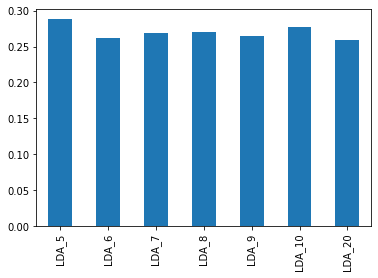

In [9]:
coherence_scores = pd.DataFrame([kanye_lda_5_coherence, 
                                 kanye_lda_6_coherence, 
                                 kanye_lda_7_coherence, 
                                 kanye_lda_8_coherence, 
                                 kanye_lda_9_coherence, 
                                 kanye_lda_10_coherence, kanye_lda_20_coherence])
coherence_scores.columns = ['c_v','c_uci','c_npmi','u_mass']
coherence_scores.index = ['LDA_5', 'LDA_6', 'LDA_7', 'LDA_8', 'LDA_9','LDA_10', 'LDA_20']
coherence_scores['c_v'].plot.bar()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


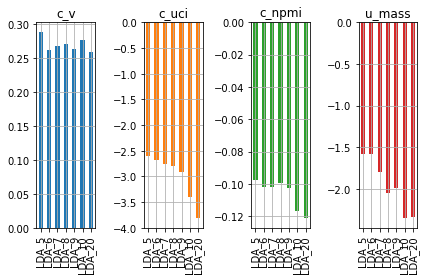

In [10]:
coherence_scores.plot(kind='bar', subplots = True, layout = (1,4), sharex = True, legend = False, grid = True)
plt.tight_layout()


### Coherence Scores


- C_v - higher the better on a scale from 0-1
- UMass - compares a word to preceding/succeeding words and needs ordered word set. Uses pairwise score f(x)
- UCI - ever word is paried with every other word and uses pointwise mutual information (PMI)
- C_NPMI

### LDA Visuals

In [11]:
pyLDAvis.gensim.prepare(kanye_lda_5, kanye_corpus, kanye_dict)
#1 heartless, forever, panda, ecstacy, spaceship
#2 ridiculous, major, swerve, bound, workout, bound, faster
#3 dilla, frightening, menacing


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.043348  0.025094       1        1  28.641656
1      0.010976  0.060580       2        1  27.357139
0      0.038931  0.035137       3        1  20.642089
4      0.044560 -0.108404       4        1  14.600338
3     -0.137815 -0.012407       5        1   8.758777, topic_info=               Term        Freq       Total Category  logprob  loglift
1773             la  146.000000  146.000000  Default  30.0000  30.0000
102              oh  262.000000  262.000000  Default  29.0000  29.0000
287            love  206.000000  206.000000  Default  28.0000  28.0000
58              get  772.000000  772.000000  Default  27.0000  27.0000
50             feel  159.000000  159.000000  Default  26.0000  26.0000
3991            bam   62.000000   62.000000  Default  25.0000  25.0000
175            work   85.000000   85.000000  Default  24.0000  24.0000
2887          amaze   45.000000   45.000000  Default  23.0000  23.0000
3351         clique   42.000000   42.000000  Default  22.0000  22.0000
78             keep   97.000000   97.000000  Default  21.0000  21.0000
4064             ey   50.000000   50.000000  Default  20.0000  20.0000
178            yeah  206.000000  206.000000  Default  19.0000  19.0000
360      hallelujah   38.000000   38.000000  Default  18.0000  18.0000
544           jesus   59.000000   59.000000  Default  17.0000  17.0000
415             god  110.000000  110.000000  Default  16.0000  16.0000
503             yes   38.000000   38.000000  Default  15.0000  15.0000
700           music   41.000000   41.000000  Default  14.0000  14.0000
1049            woo   45.000000   45.000000  Default  13.0000  13.0000
1581            hey   97.000000   97.000000  Default  12.0000  12.0000
118           round   62.000000   62.000000  Default  11.0000  11.0000
1727        forever   55.000000   55.000000  Default  10.0000  10.0000
182            body   41.000000   41.000000  Default   9.0000   9.0000
194           kanye   56.000000   56.000000  Default   8.0000   8.0000
67             high   99.000000   99.000000  Default   7.0000   7.0000
923          swerve   48.000000   48.000000  Default   6.0000   6.0000
1010            ooh   80.000000   80.000000  Default   5.0000   5.0000
1066           deep   23.000000   23.000000  Default   4.0000   4.0000
379         brother   36.000000   36.000000  Default   3.0000   3.0000
2776          study   24.000000   24.000000  Default   2.0000   2.0000
1774            lah   18.000000   18.000000  Default   1.0000   1.0000
2882      heartless   11.137993   11.854752   Topic1  -6.8148   1.1879
1727        forever   52.108976   55.754019   Topic1  -5.2718   1.1827
4051          panda    9.310932   10.023489   Topic1  -6.9939   1.1766
1290        ecstasy   19.402199   20.984596   Topic1  -6.2597   1.1719
480       spaceship    9.259879   10.016469   Topic1  -6.9994   1.1718
4212            duh    9.221990   10.017973   Topic1  -7.0035   1.1675
3176        concert    8.373938    9.105127   Topic1  -7.1000   1.1666
1617          names    8.321109    9.096249   Topic1  -7.1063   1.1612
4628           poop    7.493293    8.192274   Topic1  -7.2111   1.1611
1802        testify    7.461580    8.189824   Topic1  -7.2154   1.1572
416      graveshift    7.445740    8.184923   Topic1  -7.2175   1.1557
4104      highlight    6.582448    7.275345   Topic1  -7.3407   1.1502
2273         profit    6.551701    7.272717   Topic1  -7.3454   1.1459
1516          award    6.551685    7.273936   Topic1  -7.3454   1.1457
4593          hello    6.547007    7.273826   Topic1  -7.3461   1.1450
4100          diddy    5.669374    6.359241   Topic1  -7.4900   1.1355
4101        equinox    5.666387    6.358791   Topic1  -7.4906   1.1350
400            fair    5.654431    6.358476   Topic1  -7.4927   1.1330
4508          genie    5.649387    6.355957   Topic1  -7.4936   1.1325
3900           ting    5.6396

In [12]:
pyLDAvis.gensim.prepare(kanye_lda_9, kanye_corpus, kanye_dict)
# 1 clique, forever, diamonds, relationship, z (jay-Z), blueprint => loyalty to Jay Z
# 2 timbuck, nike, strap, drippin => fashion / sneaker dominance (from facts song)
# 3 luther, marvin, vandross, westside, jumping, celebration, female, anita, minnie, riperton => R&B (Slow Jamz)
# 4 panda, equinox, ting / badman, rosie / muthafuckin / clouds, nori => relationship with women
# 5 study, digger, payin, nightlife, ambition, experience, ego => hustle
# 6 amaze, corny, pimpin, major, strong, toast, hpnotiq, concert => celebration
# 7 menacin / frightenin / scare - announced bipolar, medulla oblongata / genie, pinocchio => struggle
# 8 faith, ultralight vision, heal, deliver, strength, kingdom, protection, reflect => mental health healing
# 9 testify, drunk, wildin, glitter, wavey => swag

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.049519  0.019479       1        1  25.243645
0      0.034379  0.069649       2        1  14.508172
1      0.001703  0.013832       3        1  12.918077
2      0.006527  0.047901       4        1  10.464327
4      0.050786 -0.051560       5        1   9.144661
6     -0.103398  0.089007       6        1   8.608741
7      0.030800  0.015724       7        1   8.492127
3     -0.140031 -0.104252       8        1   6.686568
8      0.069716 -0.099781       9        1   3.933683, topic_info=               Term        Freq       Total Category  logprob  loglift
1773             la  156.000000  156.000000  Default  30.0000  30.0000
102              oh  275.000000  275.000000  Default  29.0000  29.0000
340           thing  121.000000  121.000000  Default  28.0000  28.0000
58              get  773.000000  773.000000  Default  27.0000  27.0000
82            light  128.000000  128.000000  Default  26.0000  26.0000
3991            bam   63.000000   63.000000  Default  25.0000  25.0000
775              ya  101.000000  101.000000  Default  24.0000  24.0000
287            love  209.000000  209.000000  Default  23.0000  23.0000
2887          amaze   46.000000   46.000000  Default  22.0000  22.0000
653            girl  134.000000  134.000000  Default  21.0000  21.0000
4064             ey   51.000000   51.000000  Default  20.0000  20.0000
189            fuck  166.000000  166.000000  Default  19.0000  19.0000
1581            hey   97.000000   97.000000  Default  18.0000  18.0000
50             feel  161.000000  161.000000  Default  17.0000  17.0000
360      hallelujah   39.000000   39.000000  Default  16.0000  16.0000
175            work   85.000000   85.000000  Default  15.0000  15.0000
136             sky   67.000000   67.000000  Default  14.0000  14.0000
4371           lift   26.000000   26.000000  Default  13.0000  13.0000
544           jesus   61.000000   61.000000  Default  12.0000  12.0000
78             keep   99.000000   99.000000  Default  11.0000  11.0000
1010            ooh   79.000000   79.000000  Default  10.0000  10.0000
3570            dem   35.000000   35.000000  Default   9.0000   9.0000
2100          drunk   22.000000   22.000000  Default   8.0000   8.0000
663             hot   35.000000   35.000000  Default   7.0000   7.0000
415             god  112.000000  112.000000  Default   6.0000   6.0000
156            tell  225.000000  225.000000  Default   5.0000   5.0000
80             know  431.000000  431.000000  Default   4.0000   4.0000
178            yeah  209.000000  209.000000  Default   3.0000   3.0000
700           music   43.000000   43.000000  Default   2.0000   2.0000
3936          gwaan   26.000000   26.000000  Default   1.0000   1.0000
1727        forever   54.580425   56.580485   Topic1  -5.0992   1.3406
3351         clique   45.592659   47.268982   Topic1  -5.2791   1.3405
3971          bound   12.129027   12.941027   Topic1  -6.6032   1.3118
4212            duh    9.369418   10.152646   Topic1  -6.8614   1.2963
2140         handle    6.579308    7.363307   Topic1  -7.2149   1.2640
2130       diamonds    6.572447    7.362345   Topic1  -7.2159   1.2631
1155         desert    5.648475    6.432750   Topic1  -7.3674   1.2466
1648   relationship    5.645058    6.433291   Topic1  -7.3681   1.2459
560         nowhere   12.095944   13.833522   Topic1  -6.6060   1.2424
3975          lovin    4.729622    5.504902   Topic1  -7.5450   1.2248
1710              z    4.720878    5.503836   Topic1  -7.5468   1.2231
1534        capitol    4.717325    5.503551   Topic1  -7.5476   1.2224
543            jack    4.715332    5.503108   Topic1  -7.5480   1.2221
1288            def    4.715458    5.503271   Topic1  -7.5480   1.2221
1273      blueprint    4.714701    5.502961   Topic1  -7.5481   1.2220
1613         mentor    4.707930    5.502479   Topic1  -7.5496   1.2206
2079        besides    4.6

In [13]:
pyLDAvis.gensim.prepare(kanye_lda_10, kanye_corpus, kanye_dict)
# Topic 0 => Dreaming Big (heartless, diamonds, forever, faster, messin, digger, harder)
# Topic 1 => Party / Stunt (swerve, ecstacy, clique, fadin, lambo/lamborghini, testify)
# Topic 2 => Mental Health (lockdown, bound, gossip, menacin, frightenin) 
# Topic 3 => Conscious (la)
# Topic 4 => Faith
# Topic 5 => Mental Health
# Topic 6 => Chill
# Topic 7 => Struggle
# Topic 8 => Clown / Stuntin
# Topic 9 => Fading / Party

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.036116  0.044651       1        1  24.254429
0     -0.061305  0.009362       2        1  13.842336
1     -0.054786  0.001790       3        1  13.450022
9      0.036941  0.041421       4        1   9.061891
6     -0.088797 -0.097816       5        1   8.675258
7     -0.018376  0.032588       6        1   8.553122
2     -0.038732  0.017473       7        1   8.424234
4      0.028497  0.062728       8        1   7.437098
3      0.091962 -0.150650       9        1   4.349675
8      0.140711  0.038453      10        1   1.951936, topic_info=               Term        Freq       Total Category  logprob  loglift
1773             la  145.000000  145.000000  Default  30.0000  30.0000
58              get  772.000000  772.000000  Default  29.0000  29.0000
340           thing  116.000000  116.000000  Default  28.0000  28.0000
102              oh  279.000000  279.000000  Default  27.0000  27.0000
82            light  128.000000  128.000000  Default  26.0000  26.0000
287            love  207.000000  207.000000  Default  25.0000  25.0000
3991            bam   64.000000   64.000000  Default  24.0000  24.0000
50             feel  160.000000  160.000000  Default  23.0000  23.0000
2887          amaze   46.000000   46.000000  Default  22.0000  22.0000
1581            hey   97.000000   97.000000  Default  21.0000  21.0000
923          swerve   46.000000   46.000000  Default  20.0000  20.0000
431             let  215.000000  215.000000  Default  19.0000  19.0000
4064             ey   51.000000   51.000000  Default  18.0000  18.0000
175            work   87.000000   87.000000  Default  17.0000  17.0000
360      hallelujah   39.000000   39.000000  Default  16.0000  16.0000
156            tell  223.000000  223.000000  Default  15.0000  15.0000
78             keep   98.000000   98.000000  Default  14.0000  14.0000
80             know  433.000000  433.000000  Default  13.0000  13.0000
1010            ooh   80.000000   80.000000  Default  12.0000  12.0000
4371           lift   22.000000   22.000000  Default  11.0000  11.0000
700           music   41.000000   41.000000  Default  10.0000  10.0000
178            yeah  213.000000  213.000000  Default   9.0000   9.0000
298           party   54.000000   54.000000  Default   8.0000   8.0000
189            fuck  169.000000  169.000000  Default   7.0000   7.0000
89             make  234.000000  234.000000  Default   6.0000   6.0000
3570            dem   35.000000   35.000000  Default   5.0000   5.0000
653            girl  135.000000  135.000000  Default   4.0000   4.0000
407            foot   21.000000   21.000000  Default   3.0000   3.0000
182            body   43.000000   43.000000  Default   2.0000   2.0000
1066           deep   23.000000   23.000000  Default   1.0000   1.0000
3351         clique   46.392798   48.068752   Topic1  -5.2217   1.3811
3971          bound   12.325176   13.137485   Topic1  -6.5472   1.3527
2126          chill   12.307986   13.135034   Topic1  -6.5486   1.3515
2882      heartless   11.382141   12.188931   Topic1  -6.6268   1.3481
1727        forever   53.433922   57.347818   Topic1  -5.0804   1.3459
4212            duh    9.514645   10.298430   Topic1  -6.8060   1.3374
2130       diamonds    6.670804    7.458817   Topic1  -7.1611   1.3049
1648   relationship    5.733447    6.514002   Topic1  -7.3125   1.2889
1155         desert    5.729863    6.512316   Topic1  -7.3132   1.2886
4483        menacin    5.721472    6.514120   Topic1  -7.3146   1.2868
4489          scare    5.712046    6.513817   Topic1  -7.3163   1.2852
4476     frightenin    5.710761    6.513637   Topic1  -7.3165   1.2850
1710              z    4.792900    5.568334   Topic1  -7.4917   1.2666
1273      blueprint    4.790695    5.567248   Topic1  -7.4922   1.2663
3823        hampton    4.791891    5.569163   Topic1  -7.4919   1.2663
1613         mentor    4.789897    5.566917

### Make Predictions

In [14]:
def topify(model, corpus):
    """
    Runs a model on a corpus of text to get a full topical range readout to append to a datafrom of the original corpus
    """
    topic_readout = [model[corpus[i]][0] for i in range(len(corpus))]

    master_df = pd.DataFrame()

    for i, scores in enumerate(topic_readout):
        while len(scores) > 0:
            current = scores.pop()
            master_df = master_df.append(pd.Series([i, current[0], round(current[1],2)]), ignore_index = True)


    master_df.columns = ['Index', 'Topics', 'Proportions']
    master_df['Topics_Clean'] =  master_df['Topics'].apply(lambda x: 'Topic ' + str(x))
    topic_representation = master_df.pivot(index = 'Index', columns = 'Topics_Clean', values = 'Proportions').reset_index().fillna(0)
    return topic_representation

kanye_9_readout = topify(kanye_lda_9, kanye_corpus)
kanye_9_readout.columns = ['Index', 'Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
kanye9 = pd.concat([kanye, kanye_9_readout.drop(['Index'], axis = 1).replace(0.00, np.nan)], axis = 1)

kanye_9_albums = kanye9[['old_kanye','albums', 'Year', 'Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']].groupby(['old_kanye','albums', 'Year']).mean().reset_index()

kanye_9_albums = kanye_9_albums.sort_values(by = 'Year', ascending = True)
kanye_9_albums

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,old_kanye,albums,Year,Jay_Z,Fashion,R&B,Relationship_with_Women,Hustle,Celebration,Struggle,Mental Health,Swag
13,1,The College Dropout,2004,0.910000,0.765000,0.930000,0.970000,1.000,0.818000,NaN,1.000,1.00
11,1,Late Registration,2005,0.645000,0.900000,0.996667,0.505000,0.935,0.851667,1.000000,NaN,0.98
10,1,Graduation,2007,0.996667,NaN,1.000000,1.000000,1.000,0.772500,0.995000,0.910,1.00
8,1,808s & Heartbreak,2008,0.990000,0.700000,0.664000,0.555000,NaN,0.477500,0.990000,0.830,NaN
12,1,My Beautiful Dark Twisted Fantasy,2010,0.703333,0.663333,0.453333,0.110000,0.110,0.305000,0.690000,0.555,0.11
9,1,Cruel Summer,2012,1.000000,0.590000,NaN,NaN,1.000,0.705000,NaN,NaN,NaN
7,0,Yeezus,2013,NaN,NaN,1.000000,NaN,NaN,0.995000,1.000000,1.000,NaN
2,0,Singles,2014,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Singles,2015,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99
0,0,Cruel Winter,2016,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
kanye9_0s = pd.concat([kanye, kanye_9_readout.drop(['Index'], axis = 1)], axis = 1)

kanye_9_0s_albums = kanye9_0s[['old_kanye','albums', 'Year', 'Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']].groupby(['old_kanye','albums', 'Year']).mean().reset_index()

kanye_9_0s_albums = kanye_9_0s_albums.sort_values(by = 'Year', ascending = True)
kanye_9_0s_albums

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,old_kanye,albums,Year,Jay_Z,Fashion,R&B,Relationship_with_Women,Hustle,Celebration,Struggle,Mental Health,Swag
13,1,The College Dropout,2004,0.056875,0.191250,0.058125,0.060625,0.187500,0.255625,0.000000,0.125000,0.062500
11,1,Late Registration,2005,0.075882,0.158824,0.175882,0.059412,0.110000,0.300588,0.058824,0.000000,0.057647
10,1,Graduation,2007,0.230000,0.000000,0.076923,0.076923,0.076923,0.237692,0.153077,0.070000,0.076923
8,1,808s & Heartbreak,2008,0.082500,0.058333,0.276667,0.185000,0.000000,0.159167,0.165000,0.069167,0.000000
12,1,My Beautiful Dark Twisted Fantasy,2010,0.162308,0.306154,0.104615,0.008462,0.008462,0.046923,0.265385,0.085385,0.008462
9,1,Cruel Summer,2012,0.250000,0.147500,0.000000,0.000000,0.250000,0.352500,0.000000,0.000000,0.000000
7,0,Yeezus,2013,0.000000,0.000000,0.142857,0.000000,0.000000,0.568571,0.142857,0.142857,0.000000
2,0,Singles,2014,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,Singles,2015,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495000
0,0,Cruel Winter,2016,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


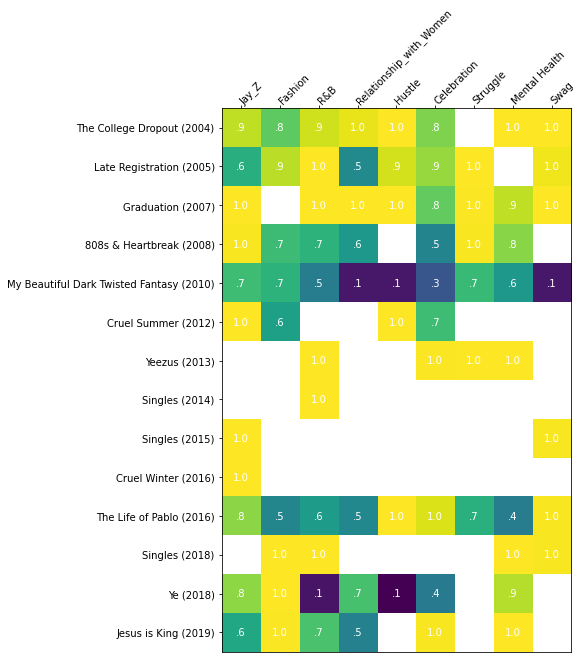

In [18]:
kanye_9_album_plot = kanye_9_albums.drop(['old_kanye', 'albums', 'Year'], axis = 1)

topics = ['Jay_Z',
 'Fashion',
 'R&B',
 'Relationship_with_Women',
 'Hustle',
 'Celebration',
 'Struggle', 'Mental Health', 'Swag']

albums = ['The College Dropout (2004)', 'Late Registration (2005)', 'Graduation (2007)', 
          '808s & Heartbreak (2008)', 'My Beautiful Dark Twisted Fantasy (2010)',
         'Cruel Summer (2012)', 'Yeezus (2013)', 'Singles (2014)', 'Singles (2015)', 'Cruel Winter (2016)',
         'The Life of Pablo (2016)', 'Singles (2018)', 'Ye (2018)', 'Jesus is King (2019)']
#kanyes = ['Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 
#          'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye']

fig, ax = plt.subplots()
im = ax.imshow(kanye_9_album_plot)

#fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)
#figure(figsize=(8, 6), dpi=80)fig = plt.figure(figsize=(6,8))


ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(albums)))
ax.xaxis.tick_top()

ax.set_xticklabels(topics)#, rotation=90)
ax.set_yticklabels(albums)
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", va="center_baseline",
         rotation_mode="anchor")


for i in range(len(albums)):
    for j in range(len(topics)):
        if kanye_9_album_plot.iloc[i, j] == 0:
            text = ax.text(j, i, '', ha='center', va='center', color='w')
        else:
            text = ax.text(j, i, round(kanye_9_album_plot.iloc[i, j], 1).astype(str).lstrip('0'), ha="center", va="center", color="w")


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


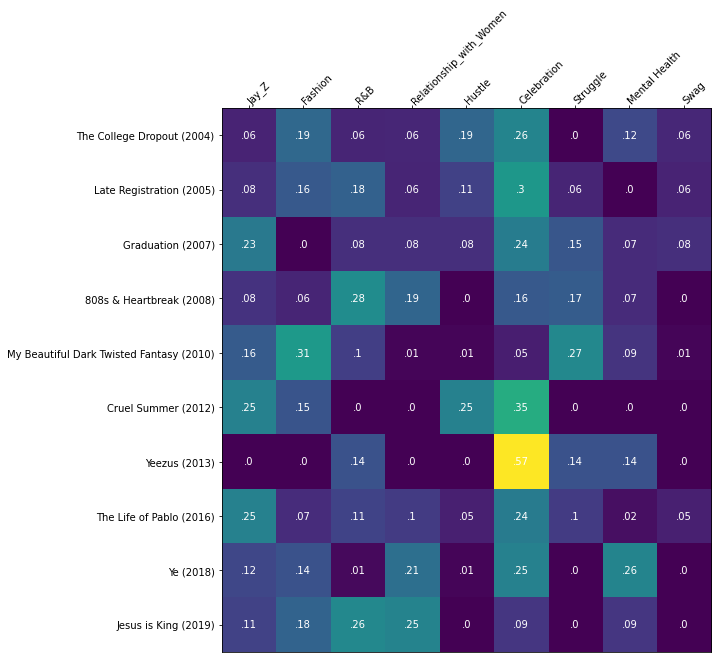

In [20]:
kanye_9_album_plot_2 = kanye_9_0s_albums[(kanye_9_0s_albums['albums'] != 'Singles') & (kanye_9_0s_albums['albums'] != 'Cruel Winter')].drop(['old_kanye', 'albums', 'Year'], axis = 1)

topics = ['Jay_Z',
 'Fashion',
 'R&B',
 'Relationship_with_Women',
 'Hustle',
 'Celebration',
 'Struggle', 'Mental Health', 'Swag']

albums = ['The College Dropout (2004)', 'Late Registration (2005)', 'Graduation (2007)', 
          '808s & Heartbreak (2008)', 'My Beautiful Dark Twisted Fantasy (2010)',
         'Cruel Summer (2012)', 'Yeezus (2013)', 
         'The Life of Pablo (2016)', 'Ye (2018)', 'Jesus is King (2019)']
#kanyes = ['Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 'Old Kanye', 
#          'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye', 'New Kanye']

fig, ax = plt.subplots()
im = ax.imshow(kanye_9_album_plot_2)

#fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)
#figure(figsize=(8, 6), dpi=80)fig = plt.figure(figsize=(6,8))


ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(albums)))
ax.xaxis.tick_top()

ax.set_xticklabels(topics)#, rotation=90)
ax.set_yticklabels(albums)
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", va="center_baseline",
         rotation_mode="anchor")


for i in range(len(albums)):
    for j in range(len(topics)):
        if kanye_9_album_plot.iloc[i, j] == 0:
            text = ax.text(j, i, '', ha='center', va='center', color='w')
        else:
            text = ax.text(j, i, round(kanye_9_album_plot_2.iloc[i, j], 2).astype(str).lstrip('0'), ha="center", va="center", color="w")


In [21]:
from scipy.stats import ttest_ind

def success_vs_fail_report(feature, data, try_log = False):
    print (feature)
    
    success_values = data[feature][data['old_kanye'] == 1]
    print ("SUCCESS", "Mean:", "{:.3f}".format(success_values.mean()), "StdDev:", "{:.3f}".format(success_values.std()))
    
    fail_values = data[feature][data['old_kanye'] == 0]
    print ("FAIL   ", "Mean:", "{:.3f}".format(fail_values.mean()), "StdDev:", "{:.3f}".format(fail_values.std()))
    
    ttest = ttest_ind(success_values, fail_values, equal_var=False)
    print ("\nTStat:", "{:.3f}".format(ttest.statistic))
    print ("P-Value", "{:.2f}\n".format(ttest.pvalue))
    if try_log:
        ttest_of_log = ttest_ind(np.log(success_values + 1), np.log(fail_values + 1), equal_var=False)
        print ("TStat (log):", "{:.3f}".format(ttest_of_log.statistic))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
kanye_9_summary_t_test = pd.concat([kanye9['old_kanye'], kanye_9_readout[['Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']]], axis = 1)

topics = ['Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']
[success_vs_fail_report(i, kanye_9_summary_t_test) for i in topics]

Jay_Z
SUCCESS Mean: 0.124 StdDev: 0.323
FAIL    Mean: 0.171 StdDev: 0.360

TStat: -0.767
P-Value 0.45

Fashion
SUCCESS Mean: 0.147 StdDev: 0.334
FAIL    Mean: 0.103 StdDev: 0.289

TStat: 0.800
P-Value 0.43

R&B
SUCCESS Mean: 0.128 StdDev: 0.324
FAIL    Mean: 0.157 StdDev: 0.352

TStat: -0.468
P-Value 0.64

Relationship_with_Women
SUCCESS Mean: 0.071 StdDev: 0.249
FAIL    Mean: 0.118 StdDev: 0.289

TStat: -0.955
P-Value 0.34

Hustle
SUCCESS Mean: 0.093 StdDev: 0.288
FAIL    Mean: 0.020 StdDev: 0.137

TStat: 1.918
P-Value 0.06

Celebration
SUCCESS Mean: 0.216 StdDev: 0.389
FAIL    Mean: 0.216 StdDev: 0.398

TStat: -0.002
P-Value 1.00

Struggle
SUCCESS Mean: 0.112 StdDev: 0.307
FAIL    Mean: 0.056 StdDev: 0.229

TStat: 1.190
P-Value 0.24

Mental Health
SUCCESS Mean: 0.065 StdDev: 0.239
FAIL    Mean: 0.099 StdDev: 0.288

TStat: -0.710
P-Value 0.48

Swag
SUCCESS Mean: 0.041 StdDev: 0.196
FAIL    Mean: 0.056 StdDev: 0.231

TStat: -0.381
P-Value 0.70



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[None, None, None, None, None, None, None, None, None]

In [25]:
kanye['albums'].unique()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['The College Dropout', 'Late Registration', 'Graduation',
       '808s & Heartbreak', 'My Beautiful Dark Twisted Fantasy',
       'Cruel Summer', 'Yeezus', 'The Life of Pablo', 'Ye', 'Singles',
       'Cruel Winter', 'Jesus is King'], dtype=object)

In [26]:
kanye_song_summary = pd.concat([kanye, kanye_9_readout], axis = 1)
kanye_song_summary.loc[kanye_song_summary.albums == 'Jesus is King'][['albums', 'track', 'Jay_Z', 
                                                                            'Fashion', 'R&B', 'Relationship_with_Women', 
                                                                            'Hustle', 'Celebration', 'Struggle', 
                                                                            'Mental Health', 'Swag']]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,albums,track,Jay_Z,Fashion,R&B,Relationship_with_Women,Hustle,Celebration,Struggle,Mental Health,Swag
117,Jesus is King,Every Hour (featuring Sunday Service Choir),0.00,1.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
118,Jesus is King,Selah,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.0,0.0
119,Jesus is King,Follow God,0.00,0.00,1.00,0.00,0.0,0.00,0.0,0.0,0.0
120,Jesus is King,Closed on Sunday,0.00,0.00,0.87,0.13,0.0,0.00,0.0,0.0,0.0
121,Jesus is King,On God,0.00,0.00,0.00,0.00,0.0,0.99,0.0,0.0,0.0
122,Jesus is King,Everything We Need (featuring Ty Dolla Sign an...,0.00,0.99,0.00,0.00,0.0,0.00,0.0,0.0,0.0
123,Jesus is King,Water (featuring Ant Clemons),0.00,0.00,0.00,0.99,0.0,0.00,0.0,0.0,0.0
124,Jesus is King,God Is,0.62,0.00,0.08,0.30,0.0,0.00,0.0,0.0,0.0
125,Jesus is King,Hands On (featuring Fred Hammond),0.00,0.00,0.96,0.04,0.0,0.00,0.0,0.0,0.0
126,Jesus is King,Use This Gospel (featuring Clipse and Kenny G),0.00,0.00,0.00,1.00,0.0,0.00,0.0,0.0,0.0


In [27]:
kanye_song_summary[['albums', 'track', 'Jay_Z', 
                                                                            'Fashion', 'R&B', 'Relationship_with_Women', 
                                                                            'Hustle', 'Celebration', 'Struggle', 
                                                                            'Mental Health', 'Swag']].sort_values(['Celebration'], ascending = False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,albums,track,Jay_Z,Fashion,R&B,Relationship_with_Women,Hustle,Celebration,Struggle,Mental Health,Swag
74,Cruel Summer,Clique (featuring Jay-z and Big Sean),0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
12,The College Dropout,"Two Words (featuring Mos Def, Freeway and The ...",0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
26,Late Registration,Diamonds from Sierra Leone (Remix) (featuring ...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
34,Graduation,Champion,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
102,Ye,I Thought About Killing You,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
44,Graduation,Homecoming (featuring Chris Martin),0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
45,Graduation,Big Brother,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
97,The Life of Pablo,30 Hours,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
93,The Life of Pablo,Real Friends,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
15,The College Dropout,Last Call,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [35]:
kanye_9_summary = kanye9_0s[['old_kanye', 'Jay_Z', 'Fashion', 'R&B', 'Relationship_with_Women',
       'Hustle', 'Celebration', 'Struggle', 'Mental Health', 'Swag']].groupby(['old_kanye']).mean().reset_index()
kanye_9_summary

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,old_kanye,Jay_Z,Fashion,R&B,Relationship_with_Women,Hustle,Celebration,Struggle,Mental Health,Swag
0,0,0.171321,0.102830,0.156604,0.117547,0.019811,0.216415,0.055849,0.098868,0.056038
1,1,0.123867,0.147067,0.128000,0.070800,0.093067,0.216267,0.112267,0.064667,0.041200


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


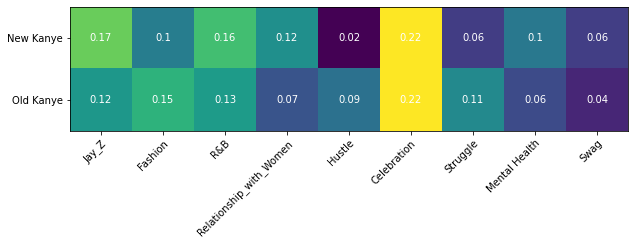

In [36]:

topics = ['Jay_Z',
 'Fashion',
 'R&B',
 'Relationship_with_Women',
 'Hustle',
 'Celebration',
 'Struggle', 'Mental Health', 'Swag']
kanyes = ['New Kanye', 'Old Kanye']

fig, ax = plt.subplots()
im = ax.imshow(kanye_9_summary.drop(['old_kanye'], axis = 1))

fig.set_size_inches(10, 10)


ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(kanyes)))

ax.set_xticklabels(topics)#, rotation=90)
ax.set_yticklabels(kanyes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(kanyes)):
    for j in range(len(topics)):
        text = ax.text(j, i, round(kanye_9_summary.drop(['old_kanye'], axis = 1).iloc[i, j], 2),
                       ha="center", va="center", color="w")
